In [2]:
stable = False # Set to True for latest pip version or False for main branch in GitHub
!pip install {"tsai -U" if stable else "git+https://github.com/timeseriesAI/tsai.git"} >> /dev/null
!pip install sktime -U  >> /dev/null


  Running command git clone -q https://github.com/timeseriesAI/tsai.git /tmp/pip-req-build-lag01tfd


In [142]:
import pandas as pd
import numpy as np
from tsai.basics import *

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm


import warnings
warnings.filterwarnings('ignore')

In [120]:
dataframe = pd.read_excel('/content/DATASET.xlsx')

In [121]:
dataframe

,Unnamed: 0,year,Para-1,Para-2,Para-3,Para-4,Para-5,Para-6,Para-7,Para-8,Para-9,Para-10,Para-11,Para-12,Para-13
0,Sec_1,1,324.0,354.5,17.0,0.0,3,117,2600,400,0.0,0.0,0.0,0,1.520
1,NaN,2,324.0,161.1,18.2,0.0,4,106,5950,1190,0.0,3.4,0.0,0,1.620
2,NaN,3,324.0,170.7,18.5,0.0,4,110,5950,1190,0.0,21.3,0.0,4,1.680
3,NaN,4,324.0,223.9,18.9,0.0,3,110,6150,1340,0.0,21.3,0.0,5,1.780
4,NaN,5,324.0,228.2,18.4,0.0,2,113,6340,1450,0.0,23.9,0.0,7,1.800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1004,NaN,6,454.0,931.8,13.6,125.0,13,116,4150,830,15.1,1.8,1.0,15,1.681
1005,NaN,7,454.0,703.0,14.5,17.0,13,118,4150,830,24.6,7.9,2.0,15,1.838
1006,NaN,8,454.0,1124.1,14.9,45.0,18,117,4200,840,119.0,15.7,2.0,16,1.862
1007,NaN,9,454.0,1462.3,13.2,62.0,27,117,4400,720,138.2,30.5,6.0,18,1.883


In [6]:
len(dataframe)

1009

As length is 1009 that means sections are not equally distributed so we have to pre process the data

In [122]:
dataframe = dataframe.drop([910,911,912,913,914,915,916,917,918])

In [64]:
dataframe

,Unnamed: 0,year,Para-1,Para-2,Para-3,Para-4,Para-5,Para-6,Para-7,Para-8,Para-9,Para-10,Para-11,Para-12,Para-13
0,Sec_1,1,324.0,354.5,17.0,0.0,3,117,2600,400,0.0,0.0,0.0,0,1.520
1,NaN,2,324.0,161.1,18.2,0.0,4,106,5950,1190,0.0,3.4,0.0,0,1.620
2,NaN,3,324.0,170.7,18.5,0.0,4,110,5950,1190,0.0,21.3,0.0,4,1.680
3,NaN,4,324.0,223.9,18.9,0.0,3,110,6150,1340,0.0,21.3,0.0,5,1.780
4,NaN,5,324.0,228.2,18.4,0.0,2,113,6340,1450,0.0,23.9,0.0,7,1.800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1004,NaN,6,454.0,931.8,13.6,125.0,13,116,4150,830,15.1,1.8,1.0,15,1.681
1005,NaN,7,454.0,703.0,14.5,17.0,13,118,4150,830,24.6,7.9,2.0,15,1.838
1006,NaN,8,454.0,1124.1,14.9,45.0,18,117,4200,840,119.0,15.7,2.0,16,1.862
1007,NaN,9,454.0,1462.3,13.2,62.0,27,117,4400,720,138.2,30.5,6.0,18,1.883


In [ ]:
len(dataframe)

In [123]:
dataframe.fillna(0,inplace=True) #replacing the NA values with the zero and making inplace equal to TRUE
#as we want to make it as change in the original dataset

In [33]:
dataframe.head(20)

,Unnamed: 0,year,Para-1,Para-2,Para-3,Para-4,Para-5,Para-6,Para-7,Para-8,Para-9,Para-10,Para-11,Para-12,Para-13
0,Sec_1,1,324.0,354.5,17.0,0.0,3,117,2600,400,0.0,0.0,0.0,0,1.520
1,0,2,324.0,161.1,18.2,0.0,4,106,5950,1190,0.0,3.4,0.0,0,1.620
2,0,3,324.0,170.7,18.5,0.0,4,110,5950,1190,0.0,21.3,0.0,4,1.680
3,0,4,324.0,223.9,18.9,0.0,3,110,6150,1340,0.0,21.3,0.0,5,1.780
4,0,5,324.0,228.2,18.4,0.0,2,113,6340,1450,0.0,23.9,0.0,7,1.800
5,0,6,324.0,225.0,17.2,0.0,4,114,6630,1500,0.0,24.9,0.0,7,1.810
6,0,7,324.0,130.0,18.4,0.0,3,103,6700,1540,0.9,25.2,0.0,7,1.860
7,0,8,324.0,100.6,19.0,0.0,2,114,6740,1590,0.9,52.8,0.0,8,1.890
8,0,9,324.0,176.5,19.0,0.0,3,108,7175,1787,3.4,60.5,57.0,8,1.920
9,0,10,324.0,53.6,19.0,0.0,2,105,7567,1885,16.8,105.0,65.0,9,1.960


In [124]:
j = 0
for i in range(100):
  dataframe.iloc[j:j + 10, 0] = dataframe.iloc[j, 0]
  j += 10

In [105]:
dataframe.head(20)

,Unnamed: 0,year,Para-1,Para-2,Para-3,Para-4,Para-5,Para-6,Para-7,Para-8,Para-9,Para-10,Para-11,Para-12,Para-13
0,Sec_1,1,324.0,354.5,17.0,0.0,3,117,2600,400,0.0,0.0,0.0,0,1.520
1,Sec_1,2,324.0,161.1,18.2,0.0,4,106,5950,1190,0.0,3.4,0.0,0,1.620
2,Sec_1,3,324.0,170.7,18.5,0.0,4,110,5950,1190,0.0,21.3,0.0,4,1.680
3,Sec_1,4,324.0,223.9,18.9,0.0,3,110,6150,1340,0.0,21.3,0.0,5,1.780
4,Sec_1,5,324.0,228.2,18.4,0.0,2,113,6340,1450,0.0,23.9,0.0,7,1.800
5,Sec_1,6,324.0,225.0,17.2,0.0,4,114,6630,1500,0.0,24.9,0.0,7,1.810
6,Sec_1,7,324.0,130.0,18.4,0.0,3,103,6700,1540,0.9,25.2,0.0,7,1.860
7,Sec_1,8,324.0,100.6,19.0,0.0,2,114,6740,1590,0.9,52.8,0.0,8,1.890
8,Sec_1,9,324.0,176.5,19.0,0.0,3,108,7175,1787,3.4,60.5,57.0,8,1.920
9,Sec_1,10,324.0,53.6,19.0,0.0,2,105,7567,1885,16.8,105.0,65.0,9,1.960


In [ ]:
#Separating the test data from the Training data 

In [125]:


#Test data
df_test = dataframe.loc[dataframe['year'] == 10]
df_test


,Unnamed: 0,year,Para-1,Para-2,Para-3,Para-4,Para-5,Para-6,Para-7,Para-8,Para-9,Para-10,Para-11,Para-12,Para-13
9,Sec_1,10,324.0,53.6,19.0,0.0,2,105,7567,1885,16.8,105.0,65.0,9,1.960
19,Sec_2,10,327.7,62.0,22.7,0.0,2,102,30525,10234,76.5,44.3,5.0,9,0.795
29,Sec_3,10,487.7,93.2,22.5,0.0,4,110,2140,1270,78.5,0.0,0.0,16,1.432
39,Sec_4,10,543.6,93.2,22.5,0.0,4,110,2140,1270,28.5,60.5,67.0,11,2.004
49,Sec_5,10,434.4,149.0,11.7,72.0,3,110,13142,6225,0.0,276.2,34.0,6,1.792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
968,Sec_97,10,514.0,1226.4,10.1,203.6,16,114,7672,303,219.7,206.2,10.0,8,1.607
978,Sec_98,10,901.0,1531.0,11.1,34.9,40,100,15150,1077,5.9,74.5,33.0,13,1.087
988,Sec_99,10,1181.0,1364.9,9.2,274.3,24,112,12500,880,131.4,72.4,18.0,12,0.996
998,Sec_100,10,662.0,1110.7,12.8,33.2,27,117,3324,1356,193.7,305.6,180.0,12,2.212


In [133]:
test = dataframe[dataframe.index % 10 == 9]
test.shape
test.tail(20)

,Unnamed: 0,year,Para-1,Para-2,Para-3,Para-4,Para-5,Para-6,Para-7,Para-8,Para-9,Para-10,Para-11,Para-12,Para-13
809,Sec_81,10,534.0,616.3,3.4,843.1,19,111,2420,650,1.9,38.7,10.0,16,2.106
819,Sec_82,10,406.0,342.9,3.9,1401.4,17,126,2320,400,0.3,46.8,13.0,9,1.611
829,Sec_83,10,406.0,593.1,2.2,1642.0,24,130,2510,610,6.0,76.9,27.0,11,1.642
839,Sec_84,10,771.0,508.4,4.0,955.7,19,114,3720,580,26.7,200.9,125.0,9,1.108
849,Sec_85,10,771.0,503.9,2.5,1481.0,19,112,4740,680,24.7,170.4,103.0,12,1.620
859,Sec_86,10,743.0,559.2,5.5,831.0,10,114,1880,270,0.0,82.3,71.0,10,2.943
869,Sec_87,10,743.0,674.5,3.9,1012.0,20,115,4510,1550,11.7,259.8,21.0,5,1.760
879,Sec_88,10,317.0,537.2,4.4,860.0,12,124,1180,170,5.7,169.6,12.0,8,1.492
889,Sec_89,10,422.0,986.4,1.4,1265.0,13,115,7070,1400,4.8,9.0,15.0,11,0.851
899,Sec_90,10,422.0,773.9,0.2,1562.0,20,115,7680,630,21.4,297.1,13.0,14,1.092


In [50]:
dataframe.head(20)

,Unnamed: 0,year,Para-1,Para-2,Para-3,Para-4,Para-5,Para-6,Para-7,Para-8,Para-9,Para-10,Para-11,Para-12,Para-13
0,Sec_1,1,324.0,354.5,17.0,0.0,3,117,2600,400,0.0,0.0,0.0,0,1.520
1,Sec_1,2,324.0,161.1,18.2,0.0,4,106,5950,1190,0.0,3.4,0.0,0,1.620
2,Sec_1,3,324.0,170.7,18.5,0.0,4,110,5950,1190,0.0,21.3,0.0,4,1.680
3,Sec_1,4,324.0,223.9,18.9,0.0,3,110,6150,1340,0.0,21.3,0.0,5,1.780
4,Sec_1,5,324.0,228.2,18.4,0.0,2,113,6340,1450,0.0,23.9,0.0,7,1.800
5,Sec_1,6,324.0,225.0,17.2,0.0,4,114,6630,1500,0.0,24.9,0.0,7,1.810
6,Sec_1,7,324.0,130.0,18.4,0.0,3,103,6700,1540,0.9,25.2,0.0,7,1.860
7,Sec_1,8,324.0,100.6,19.0,0.0,2,114,6740,1590,0.9,52.8,0.0,8,1.890
8,Sec_1,9,324.0,176.5,19.0,0.0,3,108,7175,1787,3.4,60.5,57.0,8,1.920
9,Sec_1,10,324.0,53.6,19.0,0.0,2,105,7567,1885,16.8,105.0,65.0,9,1.960


In [110]:
d_train = dataframe.loc[dataframe['year'] != 10]
d_train.head(20)

,Unnamed: 0,year,Para-1,Para-2,Para-3,Para-4,Para-5,Para-6,Para-7,Para-8,Para-9,Para-10,Para-11,Para-12,Para-13
0,Sec_1,1,324.0,354.5,17.0,0.0,3,117,2600,400,0.0,0.0,0.0,0,1.520
1,Sec_1,2,324.0,161.1,18.2,0.0,4,106,5950,1190,0.0,3.4,0.0,0,1.620
2,Sec_1,3,324.0,170.7,18.5,0.0,4,110,5950,1190,0.0,21.3,0.0,4,1.680
3,Sec_1,4,324.0,223.9,18.9,0.0,3,110,6150,1340,0.0,21.3,0.0,5,1.780
4,Sec_1,5,324.0,228.2,18.4,0.0,2,113,6340,1450,0.0,23.9,0.0,7,1.800
5,Sec_1,6,324.0,225.0,17.2,0.0,4,114,6630,1500,0.0,24.9,0.0,7,1.810
6,Sec_1,7,324.0,130.0,18.4,0.0,3,103,6700,1540,0.9,25.2,0.0,7,1.860
7,Sec_1,8,324.0,100.6,19.0,0.0,2,114,6740,1590,0.9,52.8,0.0,8,1.890
8,Sec_1,9,324.0,176.5,19.0,0.0,3,108,7175,1787,3.4,60.5,57.0,8,1.920
10,Sec_2,1,327.7,336.6,21.3,0.0,4,106,5810,2030,0.0,0.0,0.0,0,0.712


In [126]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import math



In [134]:
etr = ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features='auto', max_leaf_nodes=100,
                    min_impurity_decrease=0.0, 
                    min_samples_leaf=1,
                    min_weight_fraction_leaf=0.1,
                    n_jobs=None, oob_score=False, random_state=1, verbose=0,
                    warm_start=False)

In [135]:
predicted = {'Para-9': [], 'Para-10': [], 'Para-11': [], 'Para-12': [], 'Para-13': []}
names = ['Para-9', 'Para-10', 'Para-11', 'Para-12', 'Para-13']

In [140]:
dataframe

,Unnamed: 0,year,Para-1,Para-2,Para-3,Para-4,Para-5,Para-6,Para-7,Para-8,Para-9,Para-10,Para-11,Para-12,Para-13
0,Sec_1,1,324.0,354.5,17.0,0.0,3,117,2600,400,0.0,0.0,0.0,0,1.520
1,Sec_1,2,324.0,161.1,18.2,0.0,4,106,5950,1190,0.0,3.4,0.0,0,1.620
2,Sec_1,3,324.0,170.7,18.5,0.0,4,110,5950,1190,0.0,21.3,0.0,4,1.680
3,Sec_1,4,324.0,223.9,18.9,0.0,3,110,6150,1340,0.0,21.3,0.0,5,1.780
4,Sec_1,5,324.0,228.2,18.4,0.0,2,113,6340,1450,0.0,23.9,0.0,7,1.800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1004,Sec_101,6,454.0,931.8,13.6,125.0,13,116,4150,830,15.1,1.8,1.0,15,1.681
1005,Sec_101,7,454.0,703.0,14.5,17.0,13,118,4150,830,24.6,7.9,2.0,15,1.838
1006,Sec_101,8,454.0,1124.1,14.9,45.0,18,117,4200,840,119.0,15.7,2.0,16,1.862
1007,Sec_101,9,454.0,1462.3,13.2,62.0,27,117,4400,720,138.2,30.5,6.0,18,1.883


In [143]:


ad_fuller_result_1 = adfuller(train['Para-1'])
print('Para-1')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(train['Para-2'])

print('Para-2')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

ad_fuller_result_3 = adfuller(train['Para-3'])
print('Para-3')
print(f'ADF Statistic: {ad_fuller_result_3[0]}')
print(f'p-value: {ad_fuller_result_3[1]}')

print('\n---------------------\n')

ad_fuller_result_4 = adfuller(train['Para-4'])

print('Para-4')
print(f'ADF Statistic: {ad_fuller_result_4[0]}')
print(f'p-value: {ad_fuller_result_4[1]}')


ad_fuller_result_5 = adfuller(train['Para-5'])
print('Para-5')
print(f'ADF Statistic: {ad_fuller_result_5[0]}')
print(f'p-value: {ad_fuller_result_5[1]}')

print('\n---------------------\n')

ad_fuller_result_6 = adfuller(train['Para-6'])

print('Para-6')
print(f'ADF Statistic: {ad_fuller_result_6[0]}')
print(f'p-value: {ad_fuller_result_6[1]}')


ad_fuller_result_7 = adfuller(train['Para-7'])
print('Para-7')
print(f'ADF Statistic: {ad_fuller_result_7[0]}')
print(f'p-value: {ad_fuller_result_7[1]}')

print('\n---------------------\n')

ad_fuller_result_8 = adfuller(train['Para-8'])

print('Para-8')
print(f'ADF Statistic: {ad_fuller_result_8[0]}')
print(f'p-value: {ad_fuller_result_8[1]}')


ad_fuller_result_9 = adfuller(train['Para-9'])
print('Para-9')
print(f'ADF Statistic: {ad_fuller_result_9[0]}')
print(f'p-value: {ad_fuller_result_9[1]}')

print('\n---------------------\n')

ad_fuller_result_10 = adfuller(train['Para-10'])

print('Para-10')
print(f'ADF Statistic: {ad_fuller_result_10[0]}')
print(f'p-value: {ad_fuller_result_10[1]}')

ad_fuller_result_11 = adfuller(train['Para-11'])
print('Para-11')
print(f'ADF Statistic: {ad_fuller_result_11[0]}')
print(f'p-value: {ad_fuller_result_11[1]}')

print('\n---------------------\n')

ad_fuller_result_12 = adfuller(train['Para-12'])

print('Para-12')
print(f'ADF Statistic: {ad_fuller_result_12[0]}')
print(f'p-value: {ad_fuller_result_12[1]}')

Para-1
ADF Statistic: -3.8947075122998878
p-value: 0.002074143998179337

---------------------

Para-2
ADF Statistic: -4.0040881786727045
p-value: 0.001389254989073273
Para-3
ADF Statistic: -2.9563160896576695
p-value: 0.0391802431280202

---------------------

Para-4
ADF Statistic: -2.5991032432999686
p-value: 0.0931827504929632
Para-5
ADF Statistic: -3.2244537884159077
p-value: 0.018612121259973937

---------------------

Para-6
ADF Statistic: -6.590860201557061
p-value: 7.120570390377223e-09
Para-7
ADF Statistic: -6.0751158601226365
p-value: 1.1264344789650504e-07

---------------------

Para-8
ADF Statistic: -5.843929352697025
p-value: 3.721617541529087e-07
Para-9
ADF Statistic: -5.838181389586887
p-value: 3.832434379553969e-07

---------------------

Para-10
ADF Statistic: -6.364123893265518
p-value: 2.433508587563231e-08
Para-11
ADF Statistic: -7.331145420707662
p-value: 1.1270121780320113e-10

---------------------

Para-12
ADF Statistic: -5.996675269938784
p-value: 1.6951228238

In [151]:
 import warnings
warnings.filterwarnings('ignore')

rmse = []
N = 0
index = 0
for j in [10, 11, 12, 13, 14]:
  ans = 0
  count = 0
  for i in range(0, 1000, 10):
    xtrain = dataframe.iloc[i:i+9, 1:10]
    ytrain = dataframe.iloc[i:i+9, j]
    xtest = dataframe.iloc[i+9, 1:10].to_numpy()
    ytest = dataframe.iloc[i+9, j]
    etr.fit(xtrain, ytrain)
    ypred = etr.predict(xtest.reshape(1,-1))[0]
    predicted[names[index]].append(ypred)
    ans += (ytest - ypred)**2
    count += 1
    N += 1
  rmse.append(ans)
  index += 1
 


In [152]:
df_pred = pd.DataFrame.from_dict(predicted)
df_pred

,Para-9,Para-10,Para-11,Para-12,Para-13
0,3.200,56.855,49.59,7.98,1.907400
1,58.534,28.591,0.96,7.86,0.792600
2,70.542,0.000,0.00,13.20,1.378690
3,20.594,55.028,58.61,7.52,1.871520
4,0.000,259.336,34.00,5.99,1.760880
...,...,...,...,...,...
195,177.662,186.289,9.49,7.69,1.546750
196,5.116,69.300,23.22,11.90,1.074463
197,114.531,64.392,14.36,11.69,0.968200
198,132.751,278.360,154.87,10.78,2.109010


RMSE for Each Column

In [153]:

for i in rmse:
  print((i/count)**0.5)



63.5655281816725
63.863937666651914
25.619853766171264
14.57225984533627
0.25394288598929105


RMSE Values 

In [154]:
print((sum(rmse)/N)**0.5)

42.39804490373193


In [157]:
#this is for selecting the random 15 rows from the test data
import random
ind = []
for i in range(15):
  ind.append(random.randint(0,100))
ind

[48, 56, 45, 15, 41, 58, 19, 1, 99, 1, 86, 90, 73, 63, 97]

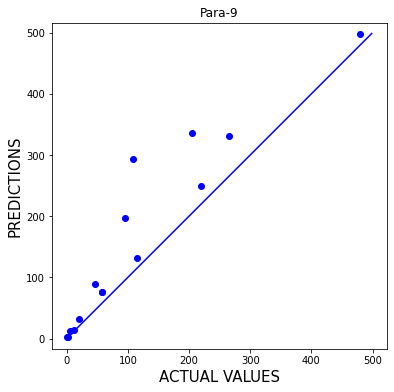

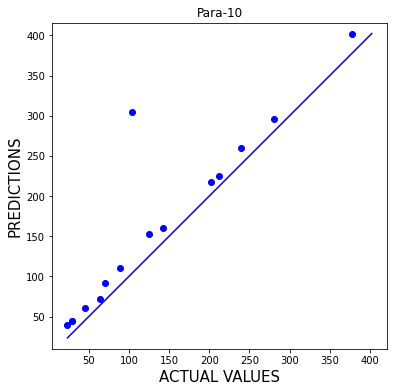

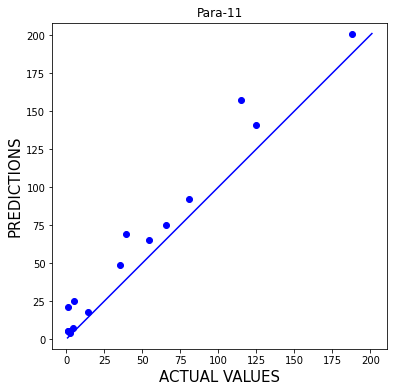

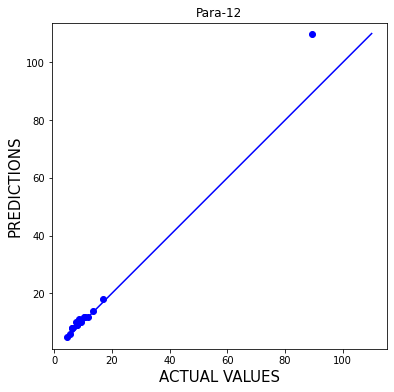

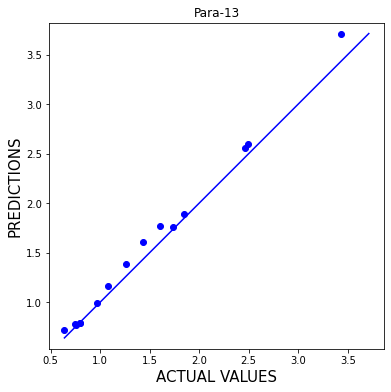

In [158]:
for i in range(5):
  plt.figure(figsize=(6,6))
  true_value = df_pred.iloc[ind, i]
  predicted_value = df_test.iloc[ind, i + 10]
  plt.scatter(true_value, predicted_value, c='blue')
  # plt.yscale('log')
  # plt.xscale('log')

  p1 = max(max(predicted_value), max(true_value))
  p2 = min(min(predicted_value), min(true_value))
  plt.plot([p1, p2], [p1, p2], 'b-')
  plt.title(names[i])
  plt.xlabel('ACTUAL VALUES', fontsize=15)
  plt.ylabel('PREDICTIONS', fontsize=15)
  plt.axis('equal')
  plt.show()